<a href="https://colab.research.google.com/github/karolinakuligowska/TMSMM_codes/blob/main/TMSMM_10_text_network_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install Bio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.4/279.4 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 52.4 MB/s eta 0:00:00


In [2]:
!pip install tqdm

In [3]:
from Bio import Entrez
from Bio import Medline
from tqdm import tqdm

In [4]:
# Change this email to your email address
Entrez.email = "email@example.com"

keyword = "optical trap"

result = Entrez.read(Entrez.esearch(db="pubmed", retmax=10, term=keyword))
print(
    "Total number of publications that contain the term {}: {}".format(
        keyword, result["Count"]
    )
)

# Fetch all ids
MAX_COUNT = result["Count"]
result = Entrez.read(
    Entrez.esearch(db="pubmed", retmax=result["Count"], term=keyword)
)

ids = result["IdList"]

batch_size = 100
batches = [ids[x: x + 100] for x in range(0, len(ids), batch_size)]

record_list = []
for batch in tqdm(batches):
    h = Entrez.efetch(db="pubmed", id=batch, rettype="medline", retmode="text")
    records = Medline.parse(h)
    record_list.extend(list(records))
print("Complete.")

Total number of publications that contain the term optical trap: 7410


100%|██████████| 75/75 [01:03<00:00,  1.18it/s]

Complete.


In [5]:
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

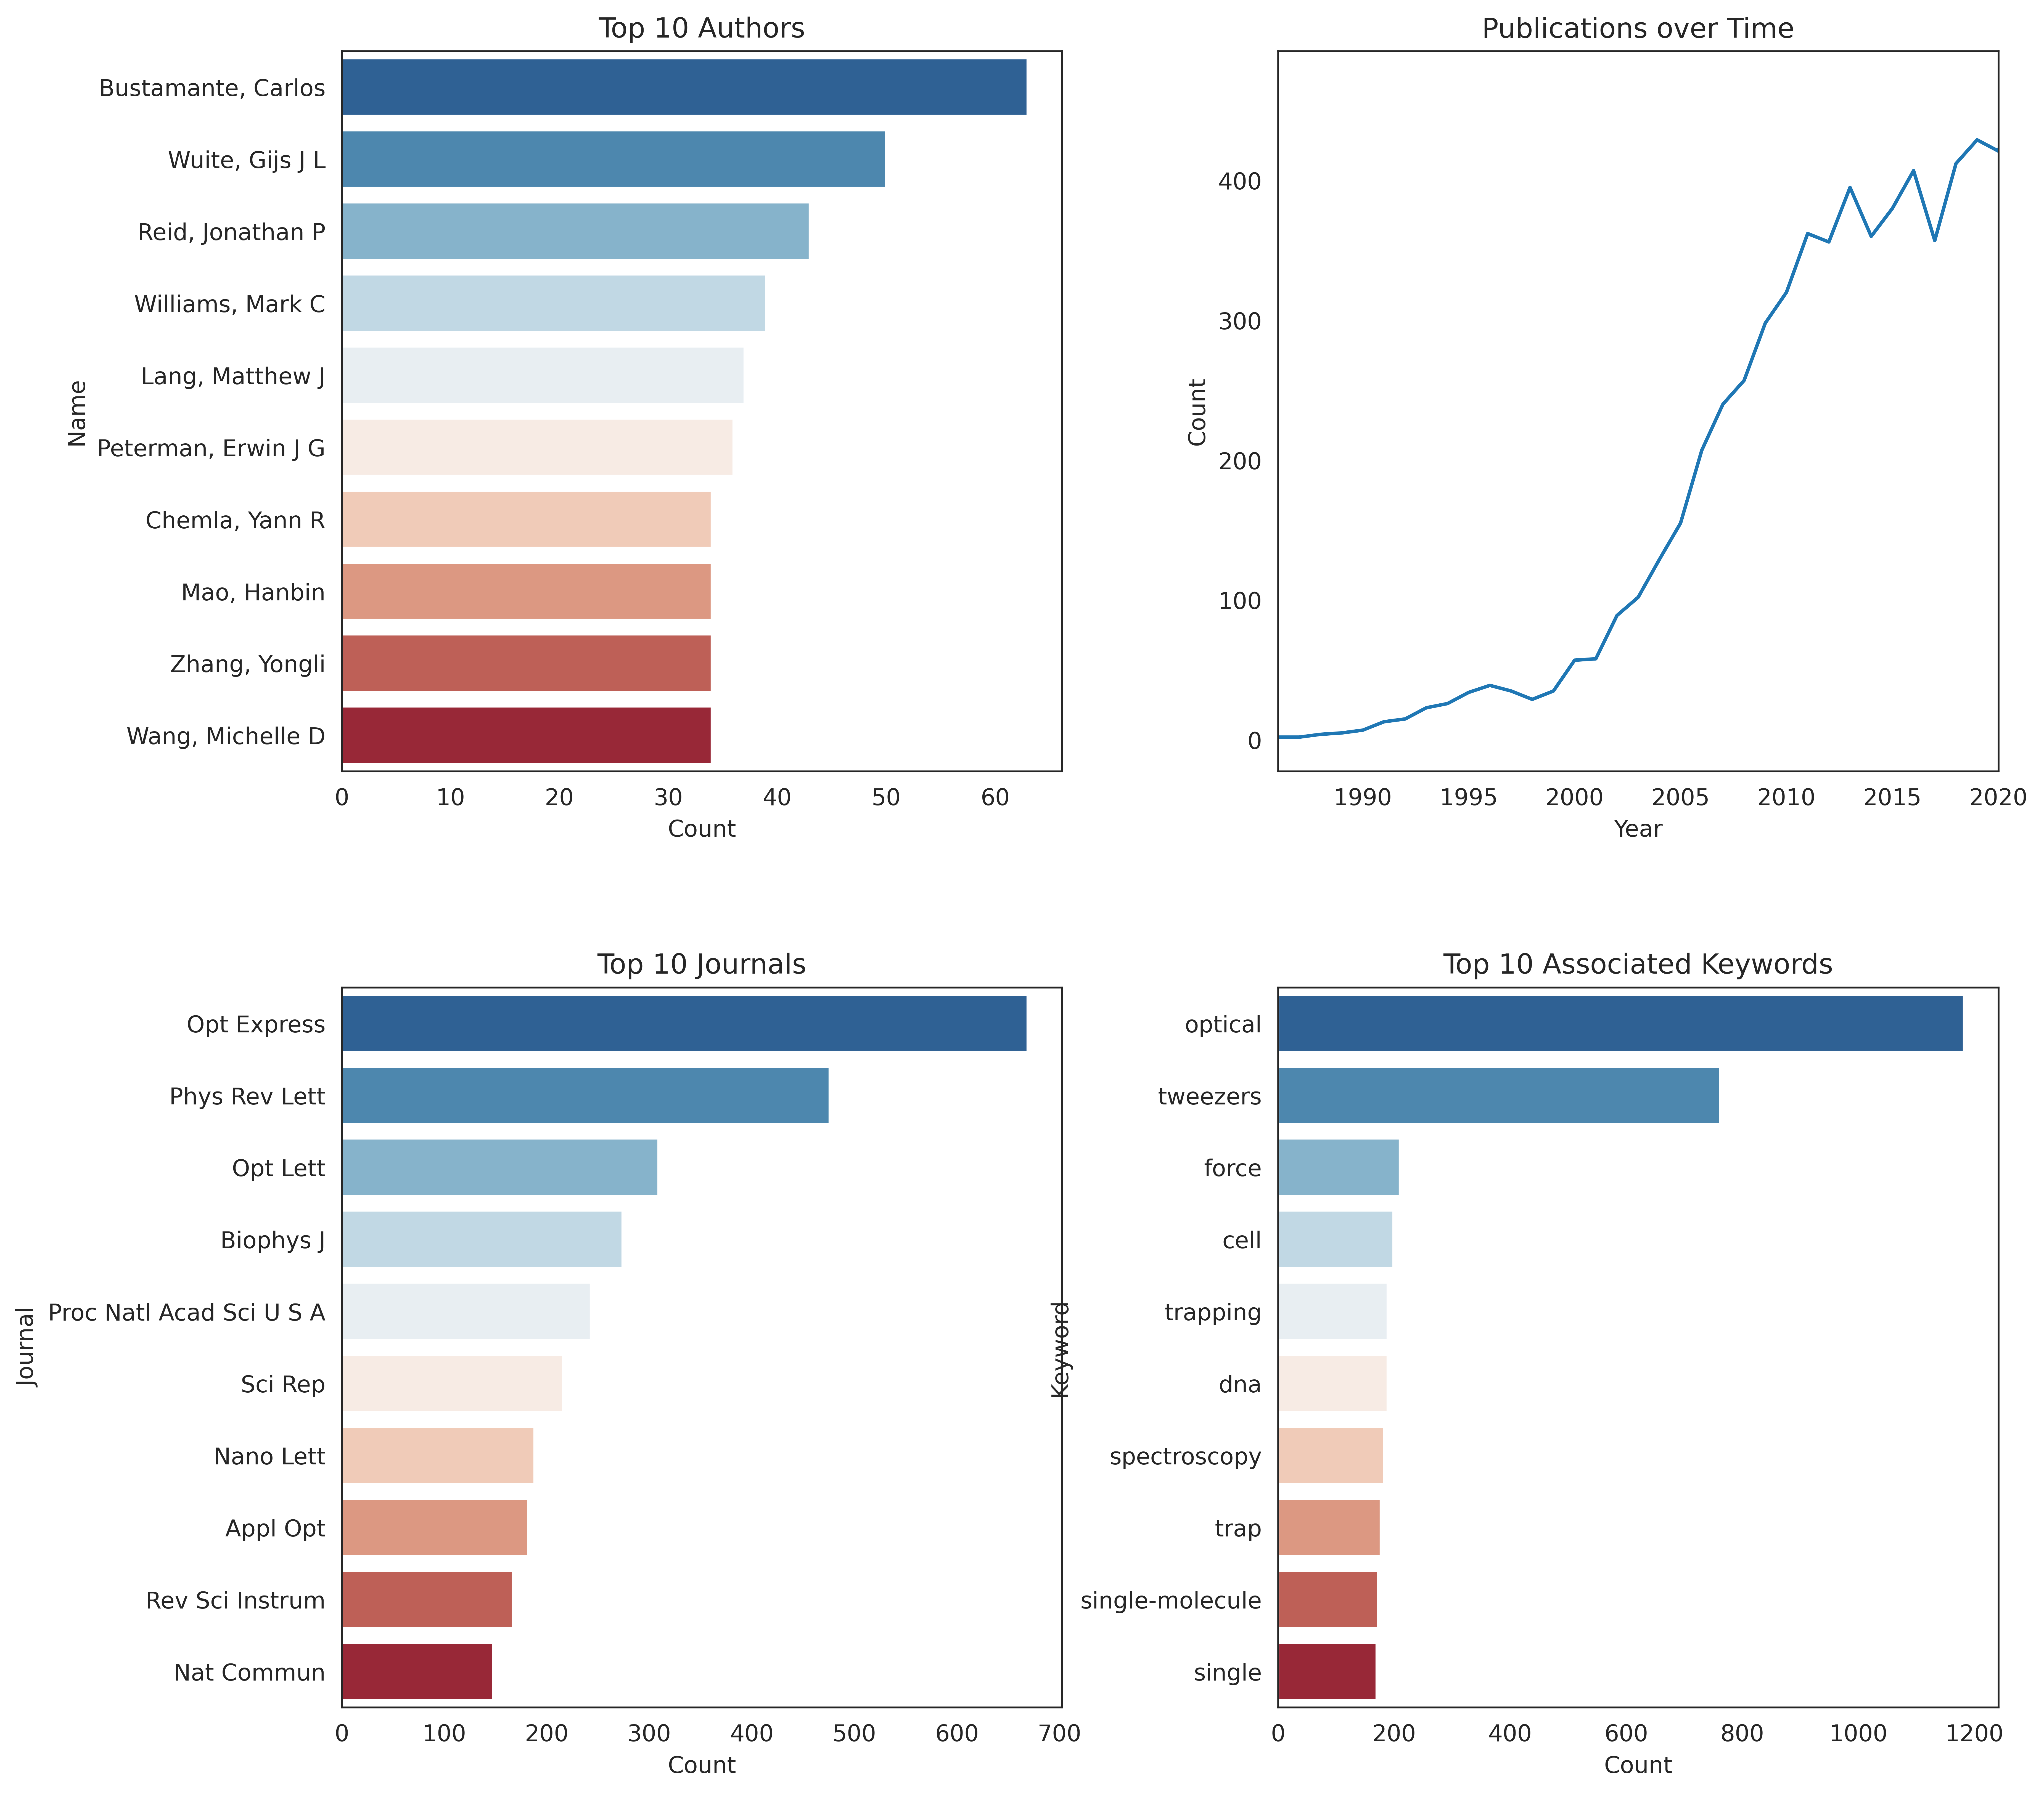

In [6]:
sns.set_style("white")

publication_data = pd.DataFrame(record_list)
publication_data.dropna(subset=['EDAT'], inplace=True)
publication_data["Year"] = (
    publication_data["EDAT"].astype(str).str[0:4].astype(int)
)

plt.figure(figsize=(10, 10), dpi=600)

# Top 10 authors
plt.subplot(2, 2, 1)
authors_flat = [
    author
    for authors in list(publication_data["FAU"].dropna())
    for author in authors
]
top10authors = pd.DataFrame.from_records(
    Counter(authors_flat).most_common(10), columns=["Name", "Count"]
)
sns.barplot(x="Count", y="Name", data=top10authors, palette="RdBu_r")
plt.title("Top 10 Authors")


# Publications over Time
plt.subplot(2, 2, 2)
yearly = pd.DataFrame(publication_data["Year"].value_counts().reset_index())
yearly.columns = ["Year", "Count"]
sns.lineplot(x="Year", y="Count", data=yearly)
plt.title("Publications over Time")
plt.xlim([1986, 2020])


plt.subplot(2, 2, 3)

# TOP 10 Journals
top10journals = pd.DataFrame.from_records(
    Counter(publication_data["TA"]).most_common(10),
    columns=["Journal", "Count"],
)

sns.barplot(x="Count", y="Journal", data=top10journals, palette="RdBu_r")
plt.title("Top 10 Journals")

# Top associated keywords
plt.subplot(2, 2, 4)

flat_kw = [
    _.lower()
    for kws in list(publication_data["OT"].dropna())
    for kw in kws
    for _ in kw.split(" ")
]

top10kw = pd.DataFrame.from_records(
    Counter(flat_kw).most_common(10), columns=["Keyword", "Count"]
)

sns.barplot(x="Count", y="Keyword", data=top10kw, palette="RdBu_r")
plt.title("Top 10 Associated Keywords")
plt.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.3, wspace=0.3)
plt.show()

In [7]:
from itertools import combinations

In [8]:
!pip install networkx

In [9]:
import networkx as nx

In [76]:
!pip install nxviz

In [77]:
from nxviz import CircosPlot

In [78]:
# Extract author connections
authors = publication_data["FAU"].dropna()
author_connections = list(
    map(lambda x: list(combinations(x[::-1], 2)), authors)
)
flat_connections = [item for sublist in author_connections for item in sublist]

# Create a dataframe with the connections
df = pd.DataFrame(flat_connections, columns=["From", "To"])
df_graph = df.groupby(["From", "To"]).size().reset_index()
df_graph.columns = ["From", "To", "Count"]


G = nx.from_pandas_edgelist(
    df_graph, source="From", target="To", edge_attr="Count"
)

# Limit to TOP 50 authors
top50authors = pd.DataFrame.from_records(
    Counter(authors_flat).most_common(50), columns=["Name", "Count"]
)

top50_nodes = (n for n in list(G.nodes()) if n in list(top50authors["Name"]))




In [79]:
G_50 = G.subgraph(top50_nodes)

In [92]:
for n in G_50.nodes():
    G_50.nodes[n]["publications"] = int(
        top50authors[top50authors["Name"] == n]["Count"]
    )


In [82]:
G_50

In [83]:
# NEW nxviz API
#
# Assume you have a graph G that is a NetworkX graph object.
# all nodes possess the "group" and "value" node attributes:
# "group" is categorical
# "value" is continuous,
# all edges have the "edge_value" attribute

import nxviz as nv


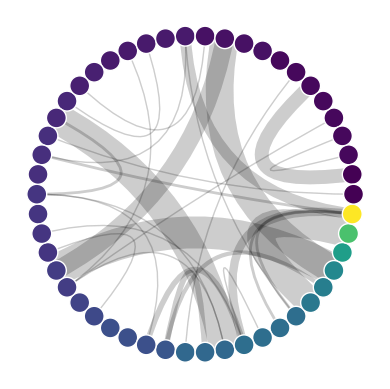

In [113]:
ax = nv.circos(
    G_50,
    group_by = "publications",
    node_color_by="publications",
    edge_lw_by = "Count"
)



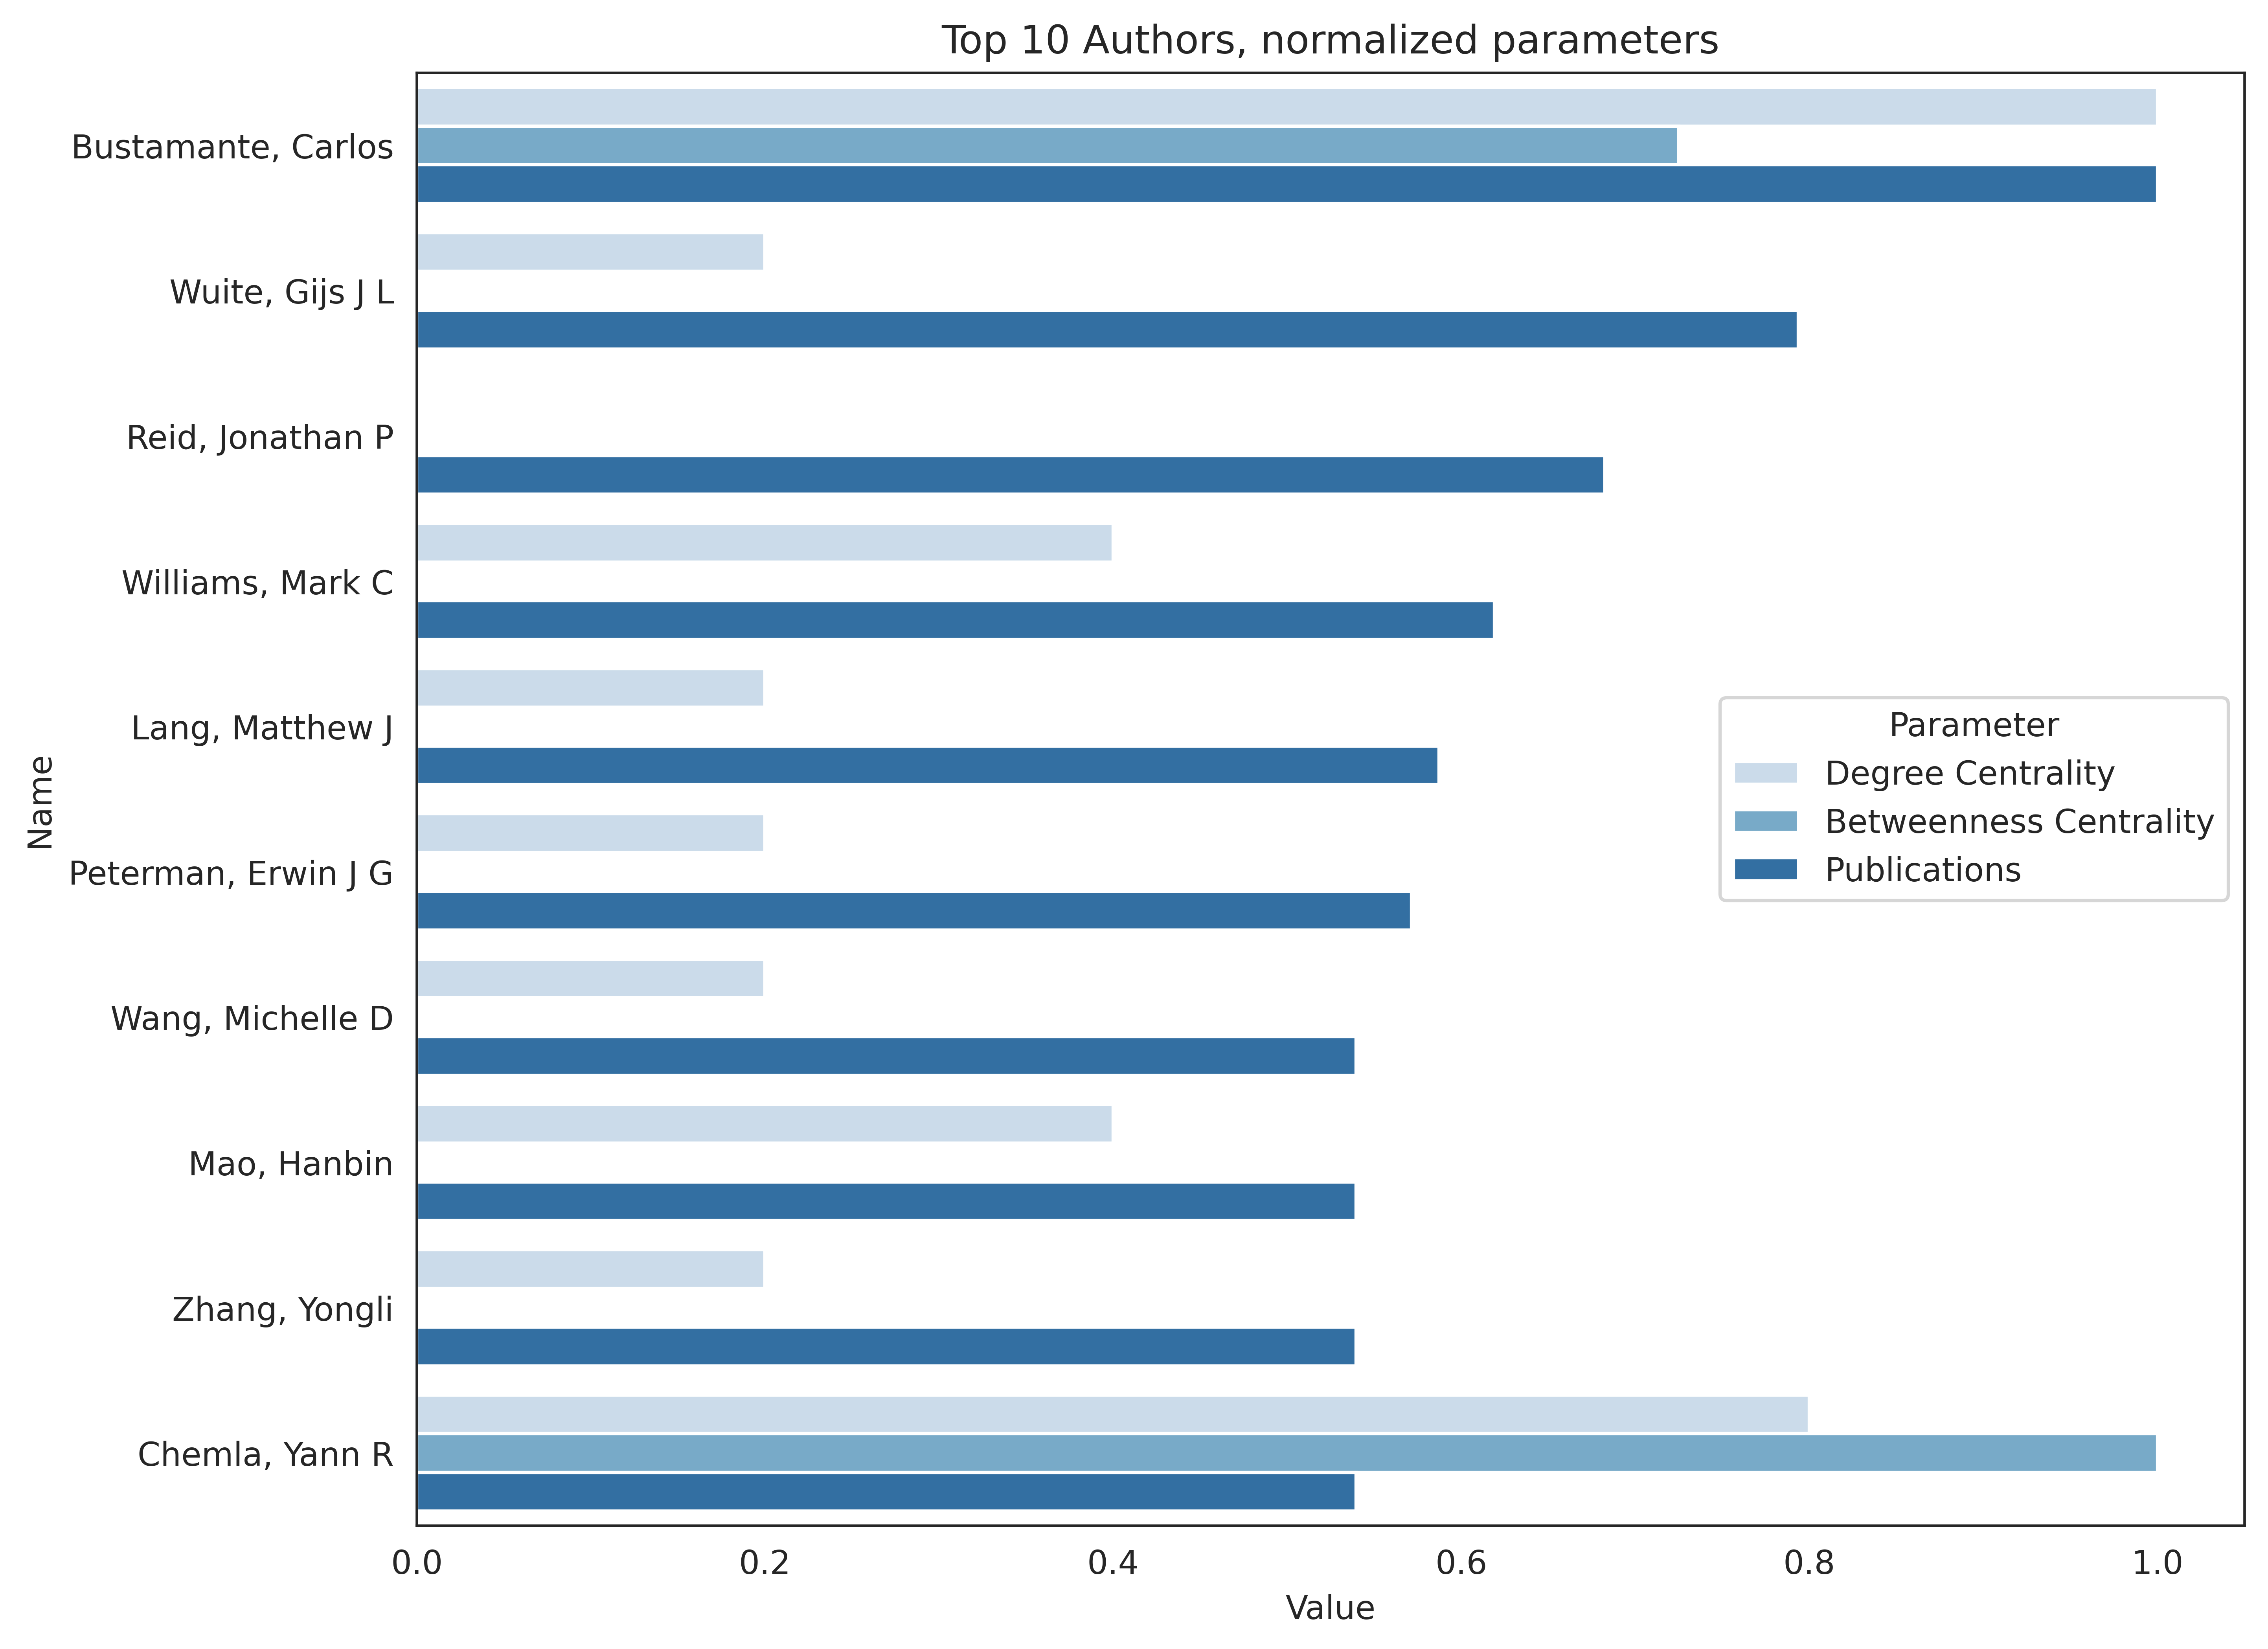

In [109]:
# how about centrality?
deg = nx.degree_centrality(G_50)
bet = nx.betweenness_centrality(G_50)

top_df = pd.DataFrame.from_dict(
    [deg, bet, dict(Counter(authors_flat).most_common(50))]
).T
top_df.columns = [
    "Degree Centrality",
    "Betweenness Centrality",
    "Publications",
]

for col in top_df.columns:
    top_df[col] = top_df[col] / max(top_df[col])

top_df = top_df.sort_values("Publications", ascending=False)[:10]
top_df = pd.DataFrame(top_df.stack())
top_df = top_df.reset_index()
top_df.columns = ["Name", "Parameter", "Value"]


fig, ax = plt.subplots(figsize=(10, 8), dpi=600)

sns.barplot(x="Value", y="Name", data=top_df, hue="Parameter", palette="Blues")

plt.title("Top 10 Authors, normalized parameters")
plt.show()

In [63]:
# finding paths
# get in touch with a person of interest
paths = list(
    nx.all_shortest_paths(G, source="Ha, Taekjip", target="Bustamante, Carlos")
)

for path in paths:
    print(path)

['Ha, Taekjip', 'Chemla, Yann R', 'Bustamante, Carlos']
['Ha, Taekjip', 'Yu, Jin', 'Bustamante, Carlos']
